**IMPORTING LIBRARIES**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

**KAGGLE**

In [3]:
#Import  libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**1.DOWNLOAD THE DATASET**

In [4]:
import pathlib
data_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=data_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


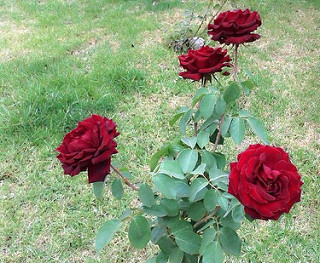

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

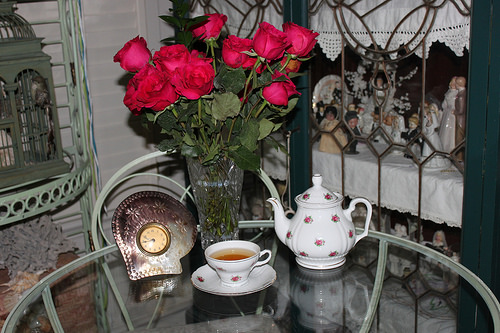

In [10]:
PIL.Image.open(str(roses[30]))

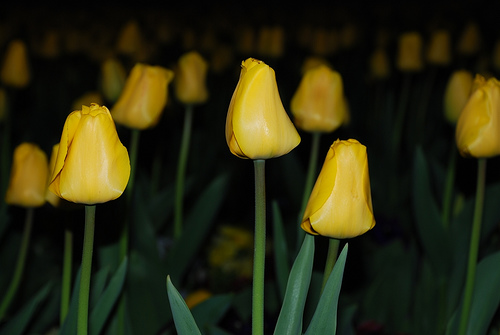

In [11]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[2]))

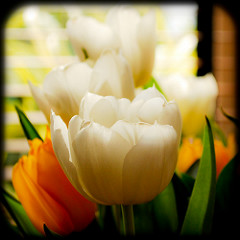

In [12]:
PIL.Image.open(str(tulips[1]))

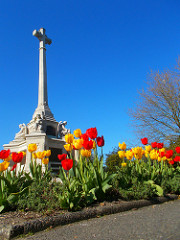

In [13]:
PIL.Image.open(str(tulips[3]))

**CREATE THE DATASET**

In [14]:
batch_size = 32
img_height = 180
img_width  = 180

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size =(img_height,img_width),
    batch_size = batch_size,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size =(img_height,img_width),
    batch_size = batch_size,
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
class_name = train_ds.class_names
print(class_name)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


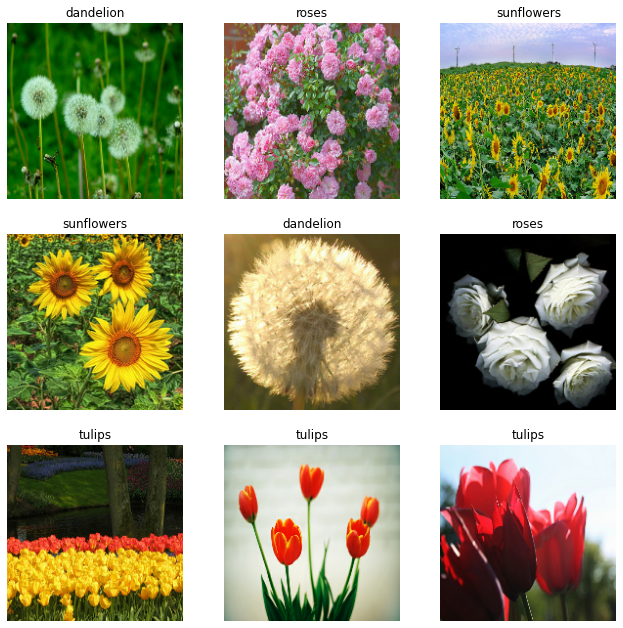

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 11))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [21]:
for image_batch , label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
normalization_layer = layers.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


**2.IMAGE AUGUMENTATION**

In [38]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

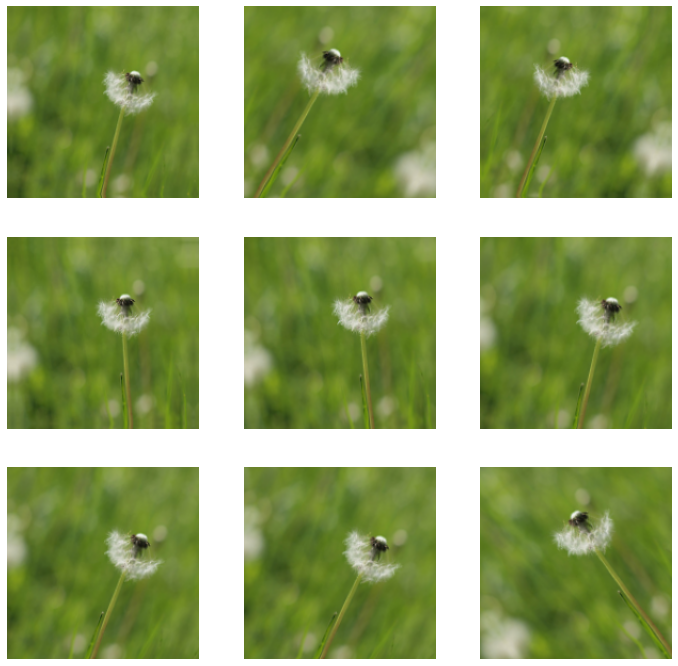

In [40]:
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**3.CREATE THE MODEL**

In [25]:
num_classes = len(class_name)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3 ,padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3 ,padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3 ,padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128, 3 ,padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(num_classes),
    
])

**4.ADD THE LAYER(CONVOLUTION,MAXPOOLING,FLATTEN,DENSE-(HIDDEN LAYERS),OUTPUT)**

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**5.COMPILE THE MODEL**

In [27]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

**6.FIT THE MODEL**

In [28]:
history = model.fit(train_ds,epochs=10, validation_data=test_ds)

Epoch 1/10
92/92 [==============================] - 107s 1s/step - loss: 1.2435 - accuracy: 0.4605 - val_loss: 1.1331 - val_accuracy: 0.5572
Epoch 2/10
92/92 [==============================] - 105s 1s/step - loss: 1.0083 - accuracy: 0.5991 - val_loss: 1.0440 - val_accuracy: 0.5913
Epoch 3/10
92/92 [==============================] - 105s 1s/step - loss: 0.8697 - accuracy: 0.6638 - val_loss: 0.9030 - val_accuracy: 0.6349
Epoch 4/10
92/92 [==============================] - 106s 1s/step - loss: 0.7492 - accuracy: 0.7115 - val_loss: 0.8710 - val_accuracy: 0.6717
Epoch 5/10
92/92 [==============================] - 108s 1s/step - loss: 0.6240 - accuracy: 0.7660 - val_loss: 0.9185 - val_accuracy: 0.6608
Epoch 6/10
92/92 [==============================] - 106s 1s/step - loss: 0.4904 - accuracy: 0.8232 - val_loss: 0.9650 - val_accuracy: 0.6458
Epoch 7/10
92/92 [==============================] - 106s 1s/step - loss: 0.3322 - accuracy: 0.8818 - val_loss: 1.1722 - val_accuracy: 0.6635
Epoch 8/10
92

**7.TEST THE MODEL**

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=10
epoch_range = range(epochs)

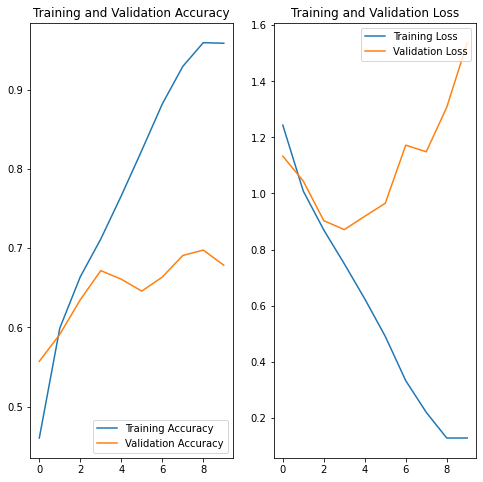

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
flower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
flower_path = tf.keras.utils.get_file('Red_flower', origin=flower_url )

131072/117948 [=================================] - 0s 0us/step


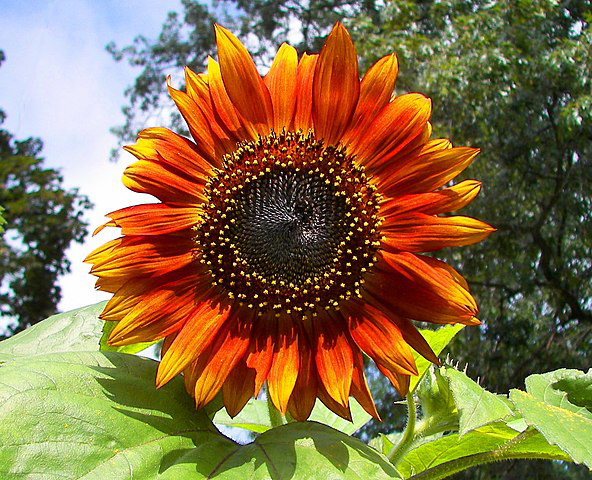

In [36]:
PIL.Image.open(flower_path)